In [25]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

In [74]:
train=pd.read_csv('train.csv')

# House price regression using TensorFlow

I have to: 

1) load the data

2) apply some basic feature engineering and cleaning

3) encode and normalize the data into something that can be efficiently computed by tensorflow

4) train the model, score it and compute metrics

5) check the model predictions visually

6) predict the house prices in the test set

Fore more info:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

https://www.tensorflow.org/tutorials/load_data/csv

https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?authuser=2

https://www.tensorflow.org/guide/keras/preprocessing_layers

In [27]:
from house_prices import feat_eng

In [28]:
int_cat_f=['SaleCondition','ExterQual','Neighborhood','KitchenQual','SaleType','PoolQC']
int_num_f=['OverallQual','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea','YearBuilt']
int_ord_f=['GarageCars','TotRmsAbvGrd']#int64

In [29]:
label='SalePrice'


### First implementation: only using numeric features and model.fit() method

In [80]:
feat_eng(train)

,SaleCondition,ExterQual,Neighborhood,KitchenQual,SaleType,PoolQC
0,Normal,Gd,CollgCr,Gd,WD,NoPool
1,Normal,TA,Veenker,TA,WD,NoPool
2,Normal,Gd,CollgCr,Gd,WD,NoPool
3,Abnorml,TA,Crawfor,Gd,WD,NoPool
4,Normal,Gd,NoRidge,Gd,WD,NoPool
...,...,...,...,...,...,...
1455,Normal,TA,Gilbert,TA,WD,NoPool
1456,Normal,TA,NWAmes,TA,WD,NoPool
1457,Normal,Ex,Crawfor,Gd,WD,NoPool
1458,Normal,TA,NAmes,Gd,WD,NoPool


In [30]:
#
x,y=train.drop(label,axis=1),train[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [31]:
train_num_feat,test_num_feat=x_train[int_num_f],x_test[int_num_f]
tf.convert_to_tensor(train_num_feat)
tf.convert_to_tensor(test_num_feat)
tf.convert_to_tensor(y_test)
tf.convert_to_tensor(y_train)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_num_feat)


In [81]:
train_num_feat

,OverallQual,LotArea,BsmtFinSF1,TotalBsmtSF,GrLivArea,GarageArea,YearBuilt
64,7,9375,739,1057,2034,645,1997
682,6,2887,1003,1291,1291,431,1996
960,5,7207,696,858,858,0,1958
1384,6,9060,204,560,1258,280,1939
1100,2,8400,290,290,438,246,1920
...,...,...,...,...,...,...,...
763,8,9430,1163,1252,2365,856,1999
835,4,9600,442,1067,1067,436,1950
1216,6,8930,0,0,1902,539,1978
559,7,3196,0,1374,1557,420,2003


In [34]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics='mean_squared_error')
  return model

In [35]:
model= get_basic_model()
history=model.fit(train_num_feat, y_train, epochs=200, batch_size=15,validation_data=(test_num_feat,y_test))


Epoch 1/200
69/69 [==============================] - 2s 13ms/step - loss: 101.7987 - mean_squared_error: 38706577408.0000 - val_loss: 68.4478 - val_mean_squared_error: 39787810816.0000
Epoch 2/200
69/69 [==============================] - 1s 8ms/step - loss: 55.1583 - mean_squared_error: 38666694656.0000 - val_loss: 44.1824 - val_mean_squared_error: 39715356672.0000
Epoch 3/200
69/69 [==============================] - 1s 8ms/step - loss: 38.4258 - mean_squared_error: 38571180032.0000 - val_loss: 32.6577 - val_mean_squared_error: 39575814144.0000
Epoch 4/200
69/69 [==============================] - 1s 9ms/step - loss: 29.2753 - mean_squared_error: 38401200128.0000 - val_loss: 25.4921 - val_mean_squared_error: 39357538304.0000
Epoch 5/200
69/69 [==============================] - 1s 9ms/step - loss: 23.2401 - mean_squared_error: 38155546624.0000 - val_loss: 20.4889 - val_mean_squared_error: 39050452992.0000
Epoch 6/200
69/69 [==============================] - 1s 9ms/step - loss: 18.9007 - 

### Excercise 2: preprocess by using keras functional API

1) Build the preprocessing model, passing data as dict

In [84]:
train[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs,AvgSF
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2008,WD,Normal,208500,1710,2.0,855.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,5,2007,WD,Normal,181500,1262,1.0,1262.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,9,2008,WD,Normal,223500,1786,2.0,893.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,2,2006,WD,Abnorml,140000,1717,2.0,858.5
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,12,2008,WD,Normal,250000,2198,2.0,1099.0


In [83]:
print(int_cat_f,int_num_f,int_ord_f)

['SaleCondition', 'ExterQual', 'Neighborhood', 'KitchenQual', 'SaleType', 'PoolQC'] ['OverallQual', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'YearBuilt'] ['GarageCars', 'TotRmsAbvGrd']


In [96]:
def df_to_inputdict(df):
    '''creates a dictionary of symbolic inputs to concatenate. Should modify in order to
    either convert all feature columns or just take a user defined selecton of them'''
    inputs ={}
    for name, column in df.items():
        dtype = column.dtype
        if name in int_cat_f:
            dtype = tf.string
            inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
        if (name in int_num_f or name in int_ord_f):
            dtype = tf.float32
            inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
        
    return inputs

In [97]:
len(df_to_inputdict(train))

15

In [98]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))
    return fun(values, axis=-1)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))


In [62]:
##### WIP ####
def model_functional_api():
    x = stack_dict(inputs, fun=tf.concat)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(numeric_features)))
    x = normalizer(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(.25)(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, x)
    
    model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=['mean_squared_error'],
                run_eagerly=True)
    return model

### Make predictions and score

In [36]:
predictions=model.predict(test_num_feat)

14/14 [==============================] - 0s 3ms/step


In [38]:
from sklearn.metrics import mean_squared_log_error, r2_score

In [59]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test).flatten()
    print(predictions.shape)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    print(z)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

14/14 [==============================] - 0s 3ms/step
(438,)
r2 coefficient:  0.6867320390732273 
msle =  0.02720091589895102
[8.10568281e-01 3.42387787e+04]


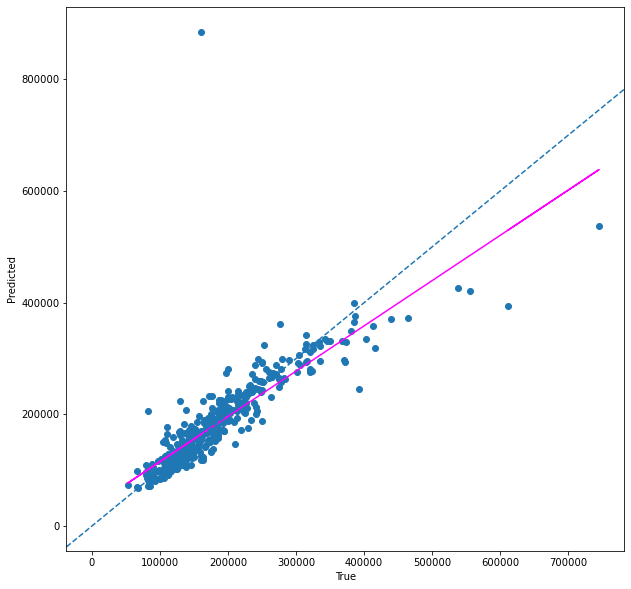

In [60]:
score_and_visualize(model=model,x_test=test_num_feat,y_test=y_test)


Save predictions

In [41]:
import datetime

In [42]:
write=False

test=pd.read_csv('test.csv')
test=test[int_num_f]
tf.convert_to_tensor(test)
pred=model.predict(test)
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction_tf.csv',index=False)

46/46 [==============================] - 0s 3ms/step


Save model

In [43]:
savemodel=False
if savemodel:
    timestamp=datetime.datetime.now().strftime("%d%m%Y%H%M%S")
    models_folder= 'models'
    os.makedirs(models_folder,exist_ok=True)
    model_name= 'model_'+ timestamp +'_tf.h5'
    modelpath= os.path.join(models_folder,model_name)
    model.save(modelpath)
    print('Saved ' , modelpath)

Saved  models\model_08112022192935_tf.h5
